## Inference Verification: Video-Text Similarity & t-SNE

Steps:
1. User provides a video folder + caption folder (one JSON per video, `summary` field = caption)
2. Minimal `InferenceVideoTextDataset` loads & matches video-caption pairs
3. User selects model config + checkpoint path
4. Load params, compute video & text embeddings
5. Similarity matrix visualization
6. t-SNE plot with user-provided labels

### 1. User Config

In [16]:
# ===== User fills in these =====

# Path to folder containing .mp4 files (<10 videos)
VIDEO_FOLDER = "/home/bingliangzhang/atlas/examples/videos"

# Path to folder containing per-video annotation JSONs
# Each video "X.mp4" should have a corresponding "{prefix}_annotations.json"
# where {prefix} is a prefix of X. Each JSON has a top-level "summary" field.
CAPTION_FOLDER = "/home/bingliangzhang/atlas/examples/captions"

# Model config name (filename under configs/jax/model/, without .yaml)
MODEL_CONFIG = "/home/bingliangzhang/atlas/configs/jax/model/gemma3_270M.yaml"  # or "videoprism", "gemma3_270M"

# Checkpoint directory (Orbax checkpoint root, e.g. logs/project/run_name)
# Set to None to use the model's pretrained weights (no checkpoint)
CHECKPOINT_DIR = '/home/bingliangzhang/atlas/logs/jax-gemma3/270M-full-finetuning-ml256-50k'  # e.g. "/atlas_raw/checkpoints/my_run"
CHECKPOINT_STEP = 10000  # None = latest step

# Labels for t-SNE plot (one per video, same order as sorted video filenames)
# Set to None to auto-generate from filenames
TSNE_LABELS = ["cat", "cat", "dog", "dog"]

# Video decode settings
NUM_FRAMES = 16
RESOLUTION = (288, 288)
SEED = 42

### 2. Minimal Dataset

In [ ]:
from __future__ import annotations

import json
import random
from pathlib import Path

import torch
from torch.utils.data import Dataset

from atlas.data.dataset.video.base import VideoTextDataSample
from atlas.data.dataset.video.utils import decode


def _match_video_to_caption(video_path: Path, caption_folder: Path) -> Path | None:
    """Find the annotation JSON for a video.

    Tries (in order):
      1. Exact match: {video_stem}_annotations.json
      2. Best prefix: the JSON whose base (strip '_annotations.json') is the
         longest prefix of the video stem.
    """
    stem = video_path.stem  # e.g. "155_dog_tennis_ball"
    exact = caption_folder / f"{stem}_annotations.json"
    if exact.exists():
        return exact

    best, best_len = None, 0
    for jf in caption_folder.glob("*_annotations.json"):
        base = jf.name.removesuffix("_annotations.json")
        if stem.startswith(base) and len(base) > best_len:
            best, best_len = jf, len(base)
    return best


class InferenceVideoTextDataset(Dataset[VideoTextDataSample]):
    """Minimal dataset: one video <-> one annotation JSON.

    Each JSON must have a top-level "summary" field used as the caption.
    Videos and JSONs are matched by filename prefix.
    """

    def __init__(
        self,
        video_folder: str | Path,
        caption_folder: str | Path,
        num_frames: int = 16,
        resolution: tuple[int, int] = (288, 288),
        seed: int = 42,
    ) -> None:
        self.num_frames = num_frames
        self.resolution = resolution
        self.rng = random.Random(seed)

        video_folder = Path(video_folder)
        caption_folder = Path(caption_folder)

        video_files = sorted(video_folder.glob("*.mp4"))
        self.samples: list[tuple[Path, str]] = []
        for vf in video_files:
            jf = _match_video_to_caption(vf, caption_folder)
            if jf is None:
                print(f"  Warning: no caption JSON for {vf.name}, skipping")
                continue
            with open(jf) as f:
                caption = json.load(f)["summary"]
            self.samples.append((vf, caption))
            print(f"  {vf.name}  <->  {jf.name}")

        print(f"Loaded {len(self.samples)} video-caption pairs")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> VideoTextDataSample:
        video_path, caption = self.samples[idx]
        video, meta = decode(
            str(video_path),
            self.num_frames,
            self.resolution,
            decode_method="decord",
            resize_method="center_crop_resize", # rand_crop_resize
            frame_sampling_method="max_stride",
            output_range="unit",
            dtype=torch.float32,
            rng=self.rng,
        )
        return VideoTextDataSample(video=video, caption=caption, meta=meta)

dataset = InferenceVideoTextDataset(
    video_folder=VIDEO_FOLDER,
    caption_folder=CAPTION_FOLDER,
    num_frames=NUM_FRAMES,
    resolution=RESOLUTION,
    seed=SEED,
)

# Quick sanity check
sample = dataset[0]
print(f"\nVideo shape: {sample.video.shape}, dtype: {sample.video.dtype}")
print(f"Caption: {sample.caption[:120]}...")

  155_cat_eating.mp4  <->  155_cat_eating_annotations.json
  155_cat_falling.mp4  <->  155_cat_falling_annotations.json
  155_dog_eating.mp4  <->  155_dog_eating_annotations.json
  155_dog_tennis.mp4  <->  155_dog_tennis_annotations.json
Loaded 4 video-caption pairs

Video shape: torch.Size([16, 288, 288, 3]), dtype: torch.float32
Caption: Initially, a tabby cat with dark grey and black stripes, a white chest, and white front paws sits upright on a light-bro...


### 3. Load Model from Config

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
from hydra.utils import instantiate
from omegaconf import OmegaConf

print(f"JAX devices: {jax.devices()}")

# Load model config
model_cfg = OmegaConf.load(MODEL_CONFIG)
print(f"Model config: {MODEL_CONFIG}")
print(OmegaConf.to_yaml(model_cfg))

# Instantiate model (loads pretrained weights)
model = instantiate(model_cfg.model, _convert_="all")
params = model.params
print(f"Model class: {type(model).__name__}")
print(f"Top-level param keys: {list(params.keys())}")

JAX devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]
Model config: /home/bingliangzhang/atlas/configs/jax/model/gemma3_270M.yaml
model:
  _target_: atlas.jax.model.gemma3.Gemma3AlignmentModel
  model_name: videoprism_lvt_public_v1_base
  gemma_model_class: Gemma3_270M
  gemma_text_only: true
  lora_rank: null
  lora_verbose: false
  use_bfloat16: false
  max_length: 64
  add_bos: true
  text_adapter:
    _target_: atlas.jax.adapter.base.MLPAdapter
    input_dim: 640
    output_dim: 768
  video_adapter: null
trainable_param_patterns:
- ^gemma/.*$
- ^text_adapter/.*$
- ^video_adapter/.*$
- ^videoprism/.*$

Model class: Gemma3AlignmentModel
Top-level param keys: ['text_adapter', 'videoprism', 'gemma']


### 4. Load Checkpoint & Compute Embeddings

In [19]:
from torch.utils.data import DataLoader

from atlas.jax.checkpointing import load_params
from atlas.jax.dataloader import collate_video_text, preprocess_video_text_batch

# Optionally override params with checkpoint
if CHECKPOINT_DIR is not None:
    ckpt_params, step = load_params(CHECKPOINT_DIR, step=CHECKPOINT_STEP)
    print(f"Loaded checkpoint from step {step}")
    params = jax.tree_util.tree_map(jnp.asarray, ckpt_params)
else:
    print("Using pretrained weights (no checkpoint)")

# Load all videos into a single batch
loader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=False,
    num_workers=0,
    collate_fn=collate_video_text,
)
batch = next(iter(loader))
video_input, texts = preprocess_video_text_batch(batch)
print(f"Video batch shape: {video_input.shape}")
print(f"Texts: {texts}")

/home/bingliangzhang/atlas/.pixi/envs/all-tpu/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:711: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
[INFO] Loaded params from /home/bingliangzhang/atlas/logs/jax-gemma3/270M-full-finetuning-ml256-50k (step 10000)


Loaded checkpoint from step 10000
Video batch shape: (4, 16, 288, 288, 3)
Texts: ['Initially, a tabby cat with dark grey and black stripes, a white chest, and white front paws sits upright on a light-brown wooden floor with its head turned toward the left of the frame. The cat then slowly rotates its head toward the center to face the camera directly and performs a slow blink as it brings its gaze to the lens. After looking toward the camera with its ears perked for several seconds, the cat remains stationary and continues to maintain a steady gaze with its mouth closed, though its tail performs a small flick. Finally, the cat turns its head back toward the left and partially closes its eyes before the video concludes.', 'The video begins with a Siamese cat standing on a white storage chest in a room featuring a wall-mounted television and a white chair. Shortly after, the cat is positioned on the edge of a bed with black and white checkered linens, from which it attempts to leap onto 

In [12]:
def l2_normalize(x: jax.Array, eps: float = 1e-8) -> jax.Array:
    return x / (jnp.linalg.norm(x, axis=-1, keepdims=True) + eps)


# Compute embeddings
tokenized = model.tokenize(texts)
video_emb = model.get_adapted_video_embeddings(params, video_input, train=False)
text_emb = model.get_adapted_text_embeddings(params, tokenized, train=False)

# Normalize
video_emb = l2_normalize(video_emb.astype(jnp.float32))
text_emb = l2_normalize(text_emb.astype(jnp.float32))

print(f"Video embedding: {video_emb.shape}, Text embedding: {text_emb.shape}")

Video embedding: (4, 768), Text embedding: (4, 768)


### 5. Similarity Matrix

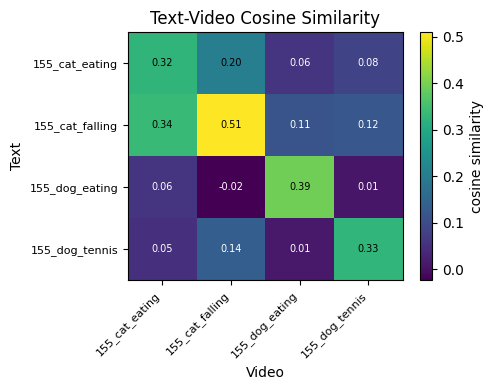

Diagonal mean:     0.3890
Off-diagonal mean: 0.0962
Gap:               0.2929


In [13]:
import matplotlib.pyplot as plt

sim_matrix = np.asarray(text_emb @ video_emb.T)
n = sim_matrix.shape[0]

# Short labels for axes
filenames = [s[0].stem for s in dataset.samples]

fig, ax = plt.subplots(figsize=(max(5, n * 0.8), max(4, n * 0.7)))
im = ax.imshow(sim_matrix, cmap="viridis", aspect="auto")
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(filenames, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(filenames, fontsize=8)
ax.set_xlabel("Video")
ax.set_ylabel("Text")
ax.set_title("Text-Video Cosine Similarity")

# Annotate cells
for i in range(n):
    for j in range(n):
        color = "white" if sim_matrix[i, j] < sim_matrix.mean() else "black"
        ax.text(j, i, f"{sim_matrix[i, j]:.2f}", ha="center", va="center", fontsize=7, color=color)

plt.colorbar(im, label="cosine similarity")
plt.tight_layout()
plt.show()

# Retrieval stats
diag_mean = float(np.mean(np.diag(sim_matrix)))
mask = ~np.eye(n, dtype=bool)
off_diag_mean = float(np.mean(sim_matrix[mask])) if n > 1 else float("nan")
print(f"Diagonal mean:     {diag_mean:.4f}")
print(f"Off-diagonal mean: {off_diag_mean:.4f}")
print(f"Gap:               {diag_mean - off_diag_mean:.4f}")

### 6. t-SNE Visualization

/tmp/ipykernel_2852903/2114521552.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_labels))
/tmp/ipykernel_2852903/2114521552.py:28: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


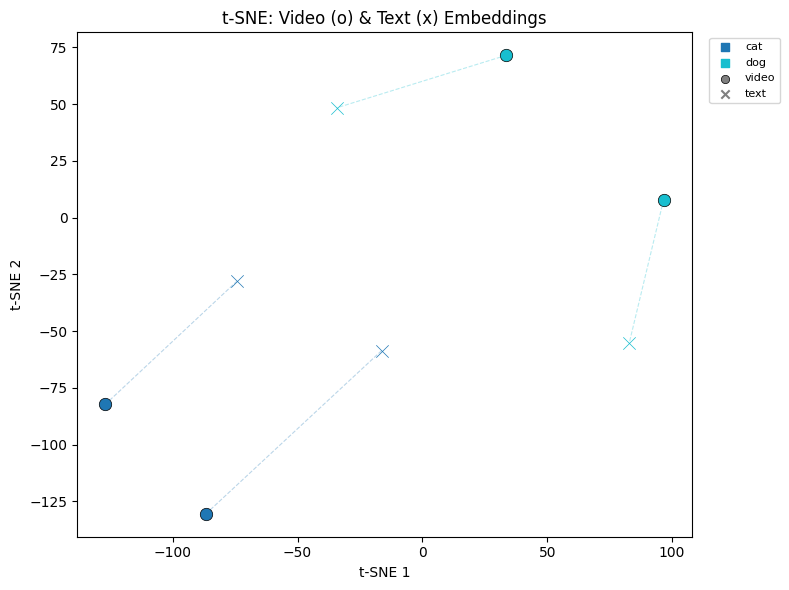

In [14]:
from sklearn.manifold import TSNE

# Prepare labels
labels = TSNE_LABELS if TSNE_LABELS is not None else filenames
assert len(labels) == n, f"Expected {n} labels, got {len(labels)}"

# Combine video and text embeddings for joint t-SNE
video_np = np.asarray(video_emb)
text_np = np.asarray(text_emb)
all_emb = np.concatenate([video_np, text_np], axis=0)  # (2N, D)
modality = ["video"] * n + ["text"] * n
all_labels = list(labels) + list(labels)

# t-SNE
perplexity = min(5, max(2, len(all_emb) - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=SEED, init="pca", learning_rate="auto")
coords = tsne.fit_transform(all_emb)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
unique_labels = sorted(set(labels))
cmap = plt.cm.get_cmap("tab10", len(unique_labels))
label_to_color = {lab: cmap(i) for i, lab in enumerate(unique_labels)}

for i in range(len(all_emb)):
    color = label_to_color[all_labels[i]]
    marker = "o" if modality[i] == "video" else "x"
    ax.scatter(
        coords[i, 0], coords[i, 1],
        c=[color], marker=marker, s=80,
        edgecolors="k" if marker == "o" else "none", linewidths=0.5,
    )

# Draw lines connecting matched video-text pairs
for i in range(n):
    ax.plot(
        [coords[i, 0], coords[n + i, 0]],
        [coords[i, 1], coords[n + i, 1]],
        color=label_to_color[labels[i]], alpha=0.3, linestyle="--", linewidth=0.8,
    )

# Legend for labels
for lab in unique_labels:
    ax.scatter([], [], c=[label_to_color[lab]], marker="s", label=lab)
# Legend for modality
ax.scatter([], [], c="gray", marker="o", label="video", edgecolors="k", linewidths=0.5)
ax.scatter([], [], c="gray", marker="x", label="text")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
ax.set_title("t-SNE: Video (o) & Text (x) Embeddings")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.tight_layout()
plt.show()